## Preprocessing

### Import Relevant Libraries and Data

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import missingno as msno

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('weatherAUS.csv')
display(df.head())
df.info()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [2]:
data_audit = pd.DataFrame(df.dtypes, columns=['data_type'])
data_audit['missing_data'] = np.round((df.isna().sum() / len(df)) *100,2)
data_audit

,data_type,missing_data
Date,object,0.00
Location,object,0.00
MinTemp,float64,1.02
MaxTemp,float64,0.87
Rainfall,float64,2.24
Evaporation,float64,43.17
Sunshine,float64,48.01
WindGustDir,object,7.10
WindGustSpeed,float64,7.06
WindDir9am,object,7.26


<Axes: >

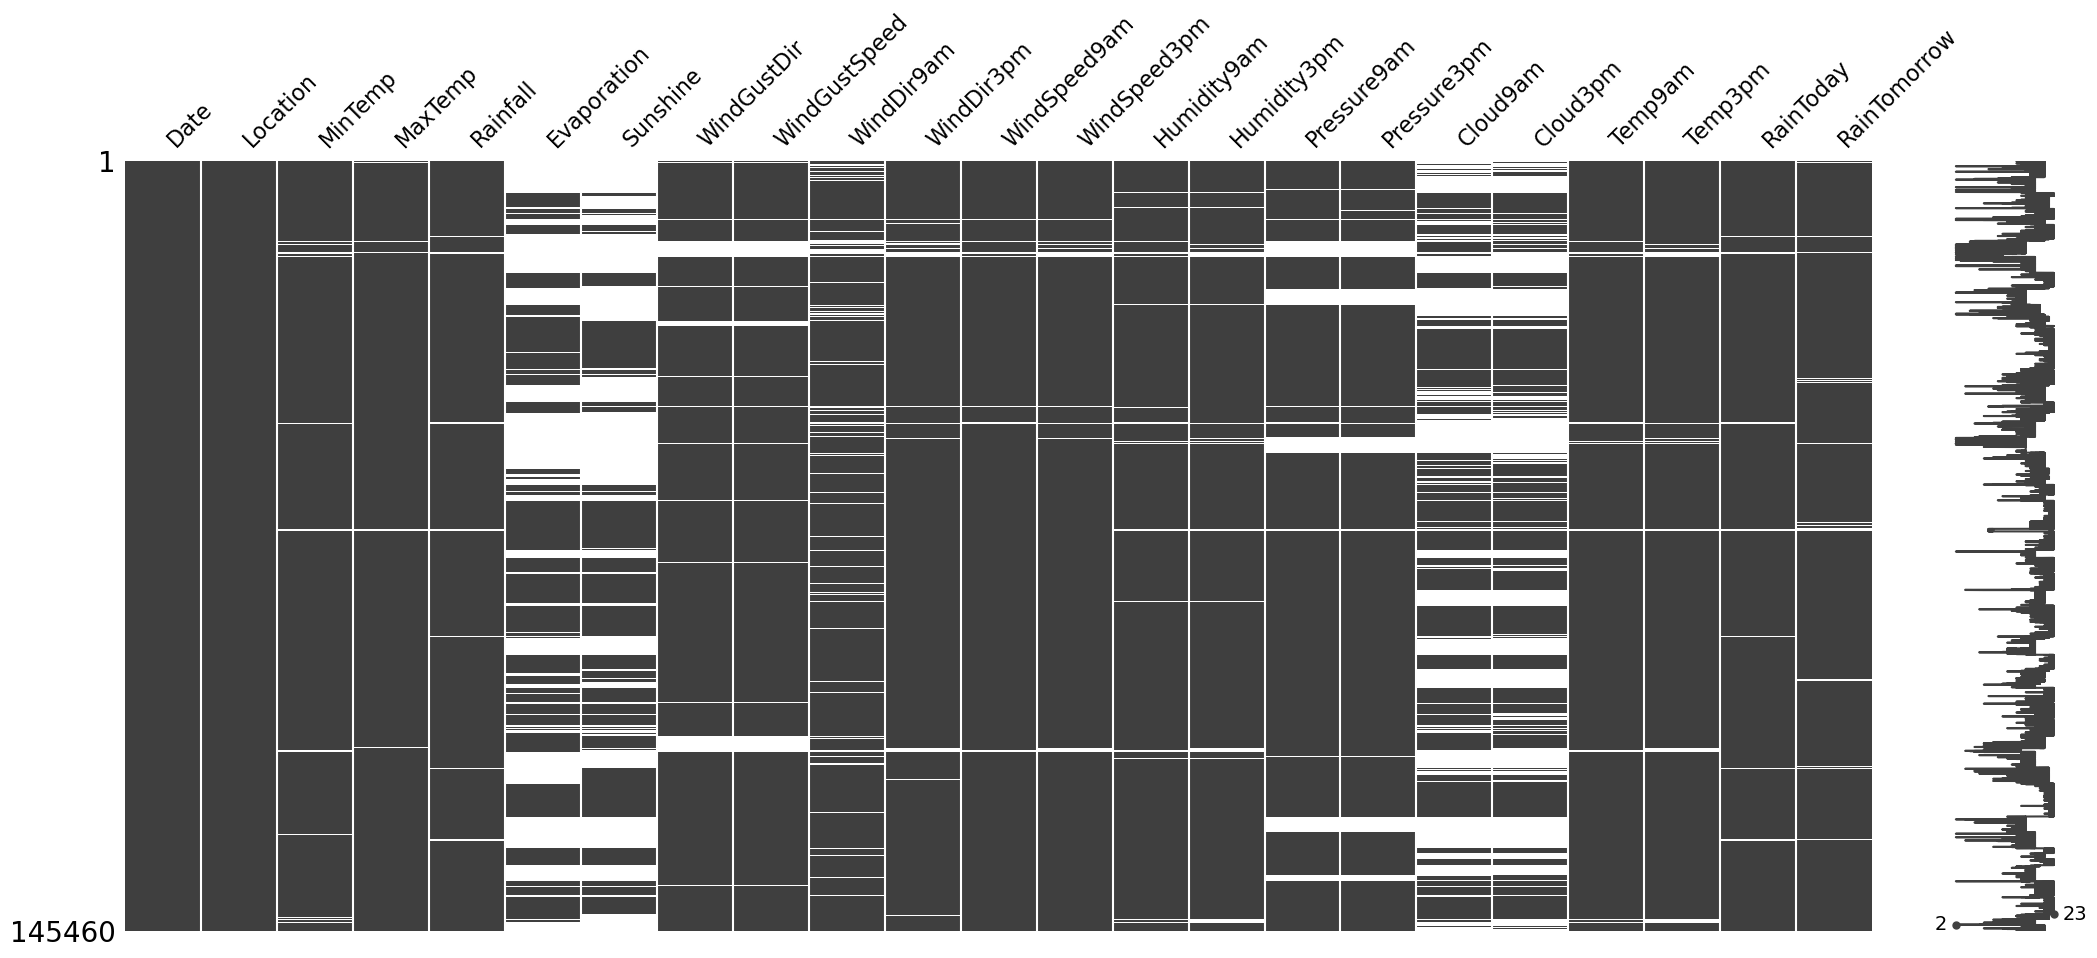

In [3]:
msno.matrix(df)

/tmp/ipykernel_8879/3515688115.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')


<Axes: >

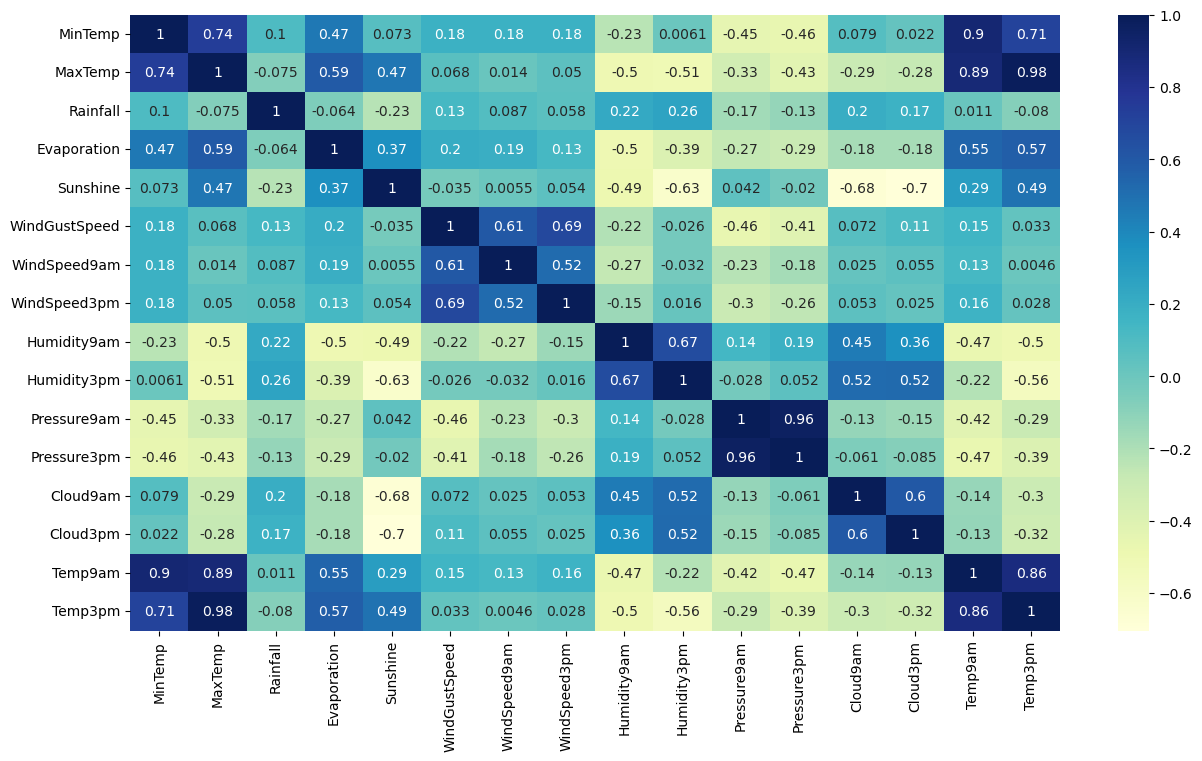

In [4]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')

### Transforming and Adding Data 

**Transforming Date Column, Adding Month and Year Columns**

We had to transform the Date column into a DateTime column and then extract the Year as well as the Month from the column for further analysis. Extracting the month is useful to check for seasonality which is common when dealing with weather data. 

**Transforming RainToday and RainTomorrow Columns**

We had to transform RainToday and RainTomorrow because initially these were object columns with the categories ‘Yes’ and ‘No’. But to use them for our classification analysis the values have to be integers, 1 for ‘Yes’ and 0 for ‘No’.

**Transforming Wind Direction Columns**

For better computation wind direction data at 9 am and 3 pm was removed, and the wind direction of the highest wind speed of the day was kept while changing its values from the “compass rose” to the “azimuthal system”.

**Adding Coordinates Columns**

For our location data we added the coordinates, one column for the latitude and one column for the longitude. The coordinates can be useful for our KNN analysis. 

###  Feature Reduction 

We performed feature reduction by aggregating highly correlated columns, namely pressure, temperature, cloud and humidity, which were sampled at distinct times of the day (9am and 3pm). To address multicollinearity and streamline the dataset, we retained the mean values derived from both time points, ensuring a more parsimonious representation of the data while preserving the essential information encapsulated by these variables. 

We computed the temperature fluctuation throughout the day by determining the difference between the minimum and maximum temperature values.

We also excluded the wind speed at distinct times of the day (9am and 3pm) to reduce the redundancy and to simplify the analysis.

### Dropping Data

We will drop all values where the humidity is zero because the  theoretical  humidity can not be zero. The other outliers are kept to ensure keeping the realistic and true data to avoid unnecessary bias.

In the previous data audit we have seen that there is a lot of monthly data missing for 2007 and 2008. Additionnally 2007 and 2008 do not have all locations and also fall into a the millenium drought period so we will drop these years from the dataset.

We will also drop the location Uluru as it has only data for very few years and since it is in the middle of the desert while most of the other locations are close to the seaside we consider it as a location we extreme weather and contrary to the other locations there is no village or city.

We also drop data for the locations Sydney, Melbourne and Perth because for these locations we have Sydney Airport, Melbourne Airport, Perth Airport data and in our data audit we checked that these locations which are basically the same locations have less missing values.

Since the missing data is very location dependent, i.e. not random at all we decided to drop the locations with the most missing data, i.e. if we dropped all NaN’s these locations would no longer exist in the dataframe. This leaves us with data for 23 locations. 

###  Imputation for Missing Values

After getting rid of the locations with the most missing NaNs, we have less location dependent missing values and decided to deal with the  remaining NaNs by using KNN imputation. KNN imputation or K-Nearest Neighbor Imputation works by finding the nearest neighbors to the missing observation and then imputing it with the  K-nearest neighbor. It can be used when data is missing at random. The advantage of this imputation method is that it is easy to implement and doesn’t make any assumptions about the data. 

### 1. Transforming Data

In [5]:
#Transfoming date column to datetime type + Adding year, month
df.Date = pd.to_datetime(df.Date)
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month

In [6]:
#Tranforming RainToday and RainTomorrow to binary variables 
df['RainToday'] = df['RainToday'].replace({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].replace({'No': 0, 'Yes': 1})

In [7]:
#Tranforming Wind Directions
direction_to_angle = {'N': 0,
                      'NNE': 22.5,
                      'NE': 45,
                      'ENE': 67.5,
                      'E': 90,
                      'ESE': 112.5,
                      'SE': 135,
                      'SSE': 157.5,
                      'S': 180,
                      'SSW': 202.5,
                      'SW': 225,
                      'WSW': 247.5,
                      'W': 270,
                      'WNW': 292.5,
                      'NW': 315,
                      'NNW': 337.5}
df['WindGustDir_angle'] = df['WindGustDir'].map(direction_to_angle)
df = df.drop(columns=['WindDir9am','WindDir3pm', 'WindGustDir'])

In [8]:
all_locations_coordinates = [
    (-36.0804772, 146.9164691, 'Albury'),
    (-33.8882071, 150.7917044, 'BadgerysCreek'),
    (-31.4983333, 145.8347222, 'Cobar'),
    (-30.296241, 153.113529, 'CoffsHarbour'),
    (-29.4648, 149.8415, 'Moree'),
    (-32.92715, 151.77647, 'Newcastle'),
    (-33.2815, 151.5675, 'NorahHead'),
    (-29.0283, 167.948, 'NorfolkIsland'),
    (-33.75089, 150.69427, 'Penrith'),
    (-33.6019444, 150.75, 'Richmond'),
    (-33.8548157, 151.2164539, 'Sydney'),
    (-35.115, 147.3677778, 'WaggaWagga'),
    (-32.7986, 151.842, 'Williamtown'),
    (-34.424, 150.8931, 'Wollongong'),
    (-35.2975906, 149.1012676, 'Canberra'),
    (-35.4248, 149.0887, 'Tuggeranong'),
    (-35.5297222, 148.7711111, 'MountGinini'),
    (-37.5622, 143.8503, 'Ballarat'),
    (-36.75818, 144.28024, 'Bendigo'),
    (-38.1075, 147.0636, 'Sale'),
    (-37.8142176, 144.9631608, 'Melbourne'),
    (-34.2029, 142.2202, 'Mildura'),
    (-36.332, 141.6503, 'Nhil'),
    (-38.3635, 141.6053, 'Portland'),
    (-37.7108, 145.0833, 'Watsonia'),
    (-37.9225, 141.2738, 'Dartmoor'),
    (-27.4689682, 153.0234991, 'Brisbane'),
    (-16.9206, 145.7709, 'Cairns'),
    (-28.0167, 153.4, 'GoldCoast'),
    (-19.2569391, 146.8239536, 'Townsville'),
    (-34.9281805, 138.5999312, 'Adelaide'),
    (-37.8284, 140.7801, 'MountGambier'),
    (-34.4683, 138.9958, 'Nuriootpa'),
    (-31.1994, 136.8254, 'Woomera'),
    (-35.0031, 117.865, 'Albany'),
    (-34.0263, 115.1001, 'Witchcliffe'),
    (-31.665, 116.0183, 'PearceRAAF'),
    (-31.9527121, 115.8604796, 'Perth'),
    (-32.9831, 121.643, 'SalmonGums'),
    (-34.9772, 116.7329, 'Walpole'),
    (-42.8825, 147.33, 'Hobart'),
    (-41.4385, 147.1347, 'Launceston'),
    (-23.698, 133.8816, 'AliceSprings'),
    (-12.4628, 130.8417, 'Darwin'),
    (-14.4667, 132.2667, 'Katherine'),
    (-25.3444, 131.0369, 'Uluru'), 
    (-33.9399227, 151.1752769, 'SydneyAirport'), 
    (-31.9374, 115.9665, 'PerthAirport'), 
    (-37.6697, 144.8491, 'MelbourneAirport')]

coord = pd.DataFrame(all_locations_coordinates, columns=['Latitude', 'Longitude', 'Location'])
df = df.merge(coord, on='Location', how='left')
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,WindGustDir_angle,Latitude,Longitude
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,...,NaN,16.9,21.8,0.0,0.0,2008,12,270.0,-36.080477,146.916469
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,...,NaN,17.2,24.3,0.0,0.0,2008,12,292.5,-36.080477,146.916469
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,...,2.0,21.0,23.2,0.0,0.0,2008,12,247.5,-36.080477,146.916469
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,...,NaN,18.1,26.5,0.0,0.0,2008,12,45.0,-36.080477,146.916469
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,...,8.0,17.8,29.7,0.0,0.0,2008,12,270.0,-36.080477,146.916469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,31.0,13.0,11.0,...,NaN,10.1,22.4,0.0,0.0,2017,6,90.0,-25.344400,131.036900
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,22.0,13.0,9.0,...,NaN,10.9,24.5,0.0,0.0,2017,6,337.5,-25.344400,131.036900
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,37.0,9.0,9.0,...,NaN,12.5,26.1,0.0,0.0,2017,6,0.0,-25.344400,131.036900
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,28.0,13.0,7.0,...,2.0,15.1,26.0,0.0,0.0,2017,6,135.0,-25.344400,131.036900


### 2. Feature Reduction 

In [9]:
df['Cloud'] = np.nanmean(df[['Cloud9am', 'Cloud3pm']], axis=1)
df['Pressure'] = np.nanmean(df[['Pressure9am', 'Pressure3pm']], axis=1)
df['Temperature'] = np.nanmean(df[['Temp9am', 'Temp3pm']], axis=1)
df['Humidity'] = np.nanmean(df[['Humidity9am', 'Humidity3pm']], axis=1)

df.dropna(subset=['MinTemp', 'MaxTemp'], inplace=True)
df['temp_fluctuation'] = df['MaxTemp'] - df['MinTemp']

df = df.drop(columns=['Cloud9am', 'Cloud3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Humidity9am', 'Humidity3pm', 'WindSpeed9am', 'WindSpeed3pm', 'MinTemp', 'MaxTemp'])
df.head()

/tmp/ipykernel_8879/4027449481.py:1: RuntimeWarning: Mean of empty slice
  df['Cloud'] = np.nanmean(df[['Cloud9am', 'Cloud3pm']], axis=1)
/tmp/ipykernel_8879/4027449481.py:2: RuntimeWarning: Mean of empty slice
  df['Pressure'] = np.nanmean(df[['Pressure9am', 'Pressure3pm']], axis=1)
/tmp/ipykernel_8879/4027449481.py:3: RuntimeWarning: Mean of empty slice
  df['Temperature'] = np.nanmean(df[['Temp9am', 'Temp3pm']], axis=1)
/tmp/ipykernel_8879/4027449481.py:4: RuntimeWarning: Mean of empty slice
  df['Humidity'] = np.nanmean(df[['Humidity9am', 'Humidity3pm']], axis=1)


,Date,Location,Rainfall,Evaporation,Sunshine,WindGustSpeed,RainToday,RainTomorrow,Year,Month,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,2008-12-01,Albury,0.6,NaN,NaN,44.0,0.0,0.0,2008,12,270.0,-36.080477,146.916469,8.0,1007.40,19.35,46.5,9.5
1,2008-12-02,Albury,0.0,NaN,NaN,44.0,0.0,0.0,2008,12,292.5,-36.080477,146.916469,NaN,1009.20,20.75,34.5,17.7
2,2008-12-03,Albury,0.0,NaN,NaN,46.0,0.0,0.0,2008,12,247.5,-36.080477,146.916469,2.0,1008.15,22.10,34.0,12.8
3,2008-12-04,Albury,0.0,NaN,NaN,24.0,0.0,0.0,2008,12,45.0,-36.080477,146.916469,NaN,1015.20,22.30,30.5,18.8
4,2008-12-05,Albury,1.0,NaN,NaN,41.0,0.0,0.0,2008,12,270.0,-36.080477,146.916469,7.5,1008.40,23.75,57.5,14.8


### 3. Dropping Data 

In [10]:
#dropping RainTomorrow and RainToday NAN's
df = df.dropna(subset=['RainTomorrow', 'RainToday'])
df.shape

(140086, 18)

In [11]:
#Dropping humidity == 0 data 
df = df[(df['Humidity'] != 0.0)] 
df.shape

(140085, 18)

In [12]:
#Dropping 2007 and 2008
df = df[(df['Year'] != 2007) & (df['Year'] != 2008)]
df.shape

(137803, 18)

In [13]:
#Dropping Melbourne, Perth, Sydney, Uluru
df = df[(df['Location'] != 'Melbourne')] 
df = df[(df['Location'] !='Perth')]
df = df[(df['Location'] !='Sydney')]
df = df[(df['Location'] !='Uluru')]
df.shape

(128186, 18)

In [14]:
#Dropping locations that would disappear if we dropped all NaNs
df_na = df.dropna()
locations = df_na.Location.unique()
df = df.loc[df.Location.isin(locations)]

In [15]:
data_audit = pd.DataFrame(df.dtypes, columns=['data_type'])
data_audit['missing_data'] = np.round((df.isna().sum() / len(df)) *100,2)
display(data_audit)

print(df.shape)

,data_type,missing_data
Date,datetime64[ns],0.00
Location,object,0.00
Rainfall,float64,0.00
Evaporation,float64,11.55
Sunshine,float64,19.17
WindGustSpeed,float64,2.11
RainToday,float64,0.00
RainTomorrow,float64,0.00
Year,int64,0.00
Month,int64,0.00


(67725, 18)


In [16]:
#scale the data
scaler = StandardScaler()
df_float = df.select_dtypes(include=['float']).drop(columns=['RainTomorrow', 'RainToday'])
result = scaler.fit_transform(df_float)
df_float = pd.DataFrame(result, columns = df_float.columns)
df_float
df_copy = df.drop(columns=df_float.columns).reset_index()
df = pd.merge(df_copy, df_float, left_index=True, right_index=True)
df

,index,Date,Location,RainToday,RainTomorrow,Year,Month,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,6049,2009-01-01,Cobar,0.0,0.0,2009,1,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,6050,2009-01-02,Cobar,0.0,0.0,2009,1,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,6051,2009-01-03,Cobar,0.0,0.0,2009,1,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,6052,2009-01-04,Cobar,0.0,0.0,2009,1,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,6053,2009-01-05,Cobar,0.0,0.0,2009,1,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67720,142298,2017-06-20,Darwin,0.0,0.0,2017,6,-0.254034,0.081655,0.886624,-0.423207,-0.982377,2.599572,-1.426876,-1.535792,-0.577591,1.241704,-0.561207,0.611991
67721,142299,2017-06-21,Darwin,0.0,0.0,2017,6,-0.254034,0.447225,0.249663,-0.274399,-0.757386,2.599572,-1.426876,-0.346762,-0.476492,1.241704,-0.858937,0.060015
67722,142300,2017-06-22,Darwin,0.0,0.0,2017,6,-0.254034,-0.009737,0.886624,-0.572016,-0.757386,2.599572,-1.426876,-1.733964,-0.382615,1.249270,-1.264932,0.203120
67723,142301,2017-06-23,Darwin,0.0,0.0,2017,6,-0.254034,0.127351,0.780464,-1.092846,-0.532395,2.599572,-1.426876,-1.337620,-0.490935,1.029880,0.115451,0.244007


### 5. Imputation 

Before doing a KKN imputation for the missing values, let's look at some graphical representation for the missing sunshine data 

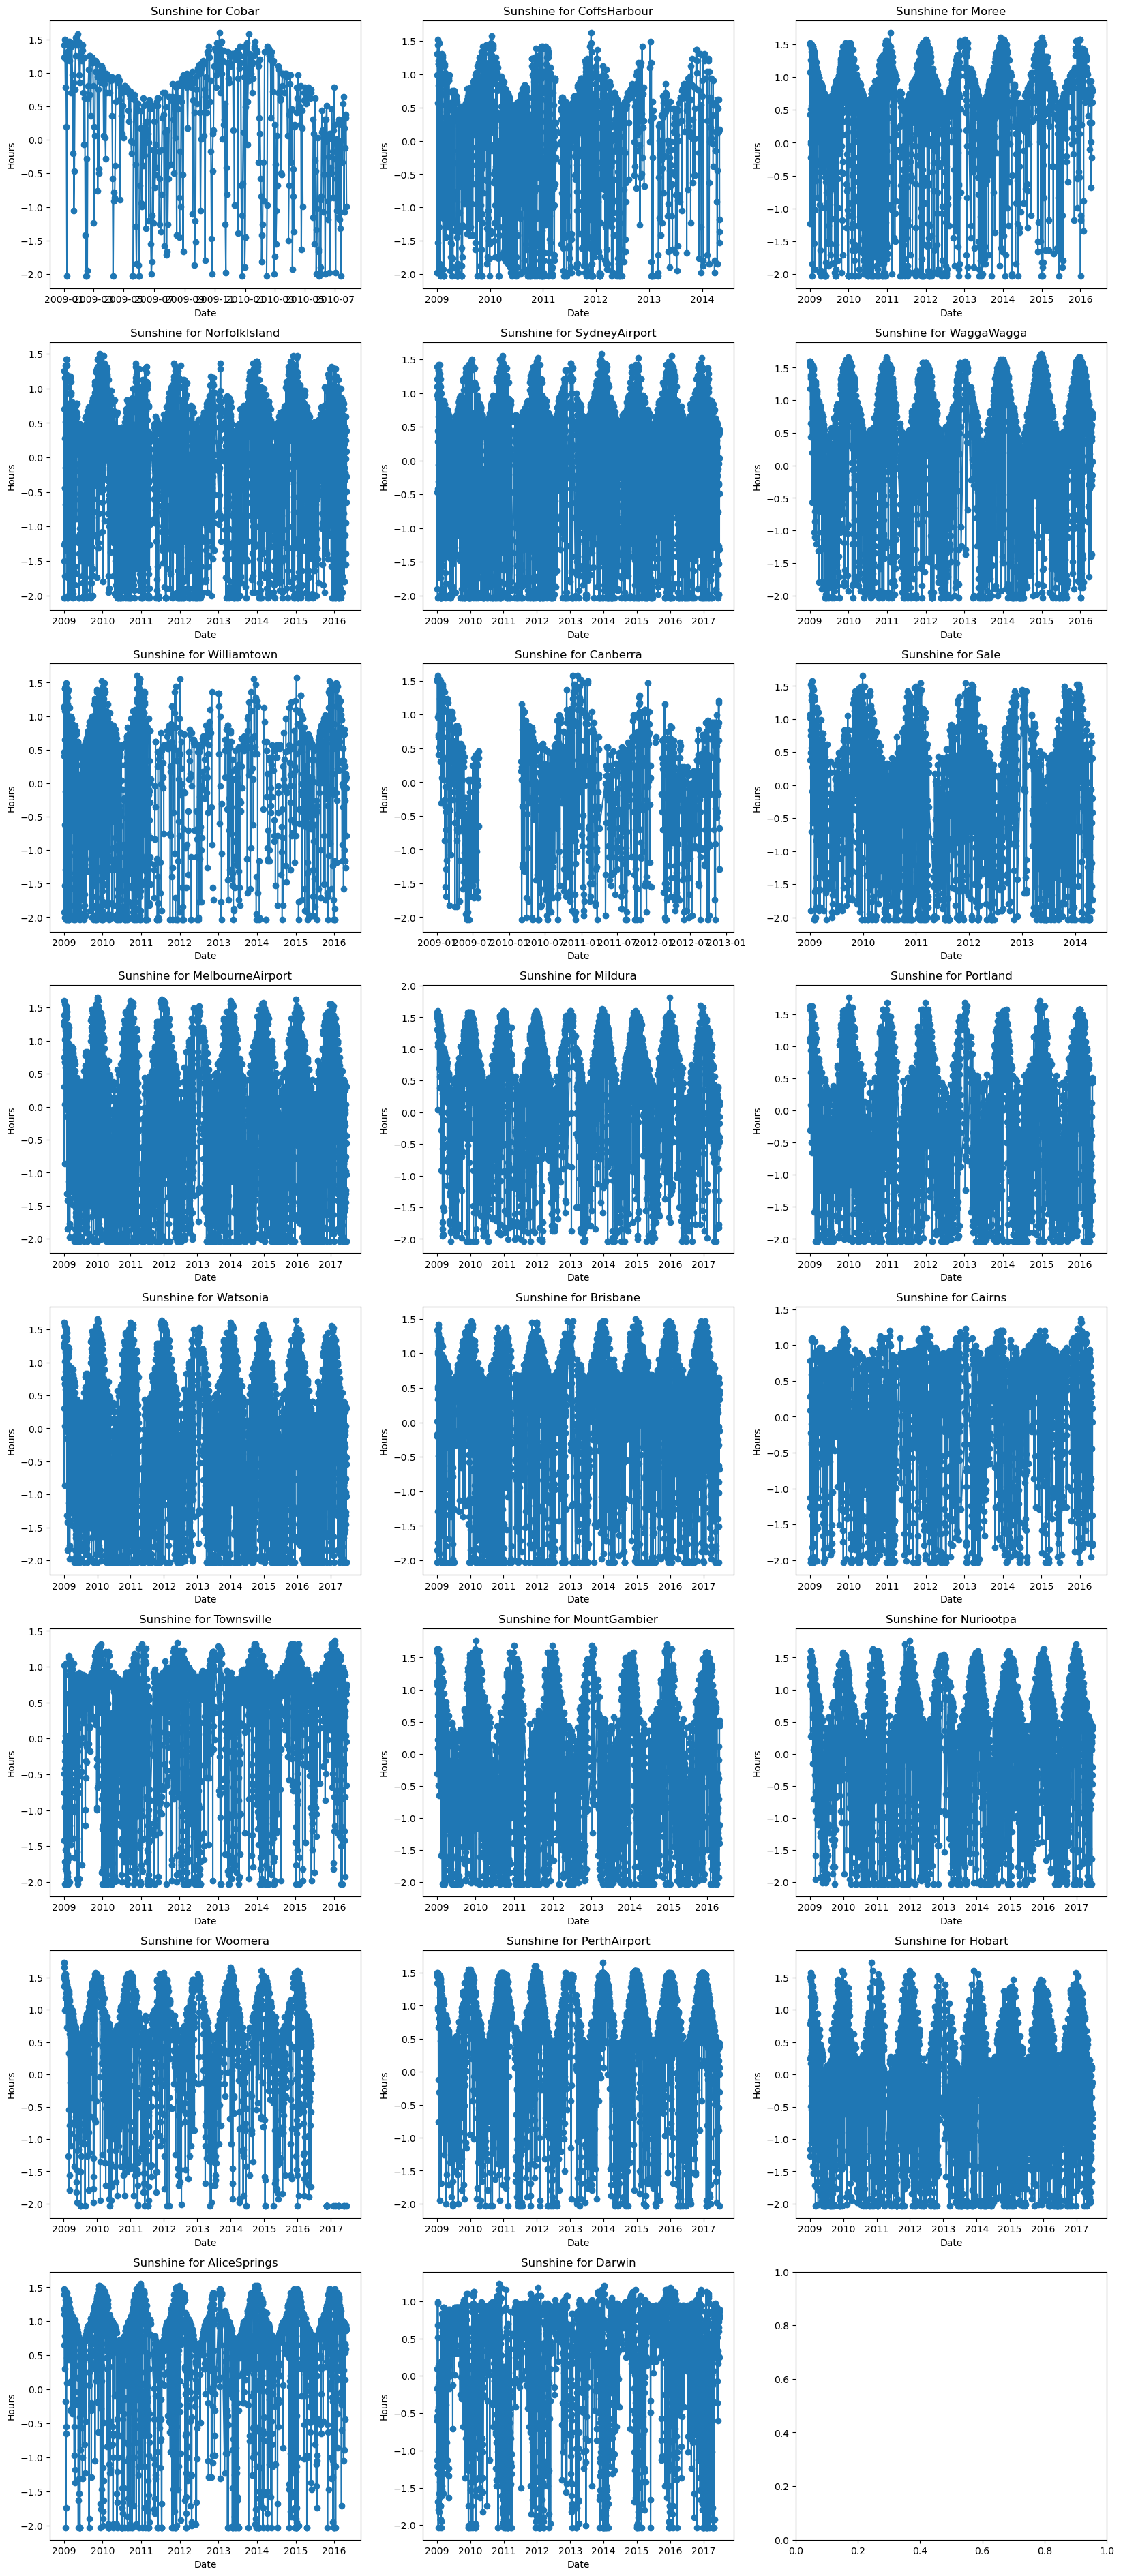

In [17]:
num_locations = len(df['Location'].unique())
num_cols = 3 # Number of columns for the subplots
num_rows = (num_locations + num_cols - 1) // num_cols

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6))

# Flatten the array for easy iteration
axs = axs.flatten()
locations = []
for i,location in enumerate(df['Location'].unique()):
    df_location = df.loc[(df.Location==location)]
    axs[i].plot(df_location.Date, df_location.Sunshine, marker='o', linestyle='-')
    axs[i].set_title(f'Sunshine for {location}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Hours')

In [18]:
imputer = KNNImputer()
df_float = df.select_dtypes(include=['float'])
imputer = KNNImputer()
result = imputer.fit_transform(df_float)

In [19]:
df_copy = df.drop(columns=df_float.columns).reset_index()
display(df_copy)
df_imputed = pd.DataFrame(result, columns = df_float.columns)
display(df_imputed)
df = pd.merge(df_copy, df_imputed, left_index=True, right_index=True)

,level_0,index,Date,Location,Year,Month
0,0,6049,2009-01-01,Cobar,2009,1
1,1,6050,2009-01-02,Cobar,2009,1
2,2,6051,2009-01-03,Cobar,2009,1
3,3,6052,2009-01-04,Cobar,2009,1
4,4,6053,2009-01-05,Cobar,2009,1
...,...,...,...,...,...,...
67720,67720,142298,2017-06-20,Darwin,2017,6
67721,67721,142299,2017-06-21,Darwin,2017,6
67722,67722,142300,2017-06-22,Darwin,2017,6
67723,67723,142301,2017-06-23,Darwin,2017,6


,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,0.0,0.0,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,0.0,0.0,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,0.0,0.0,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,0.0,0.0,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,0.0,0.0,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67720,0.0,0.0,-0.254034,0.081655,0.886624,-0.423207,-0.982377,2.599572,-1.426876,-1.535792,-0.577591,1.241704,-0.561207,0.611991
67721,0.0,0.0,-0.254034,0.447225,0.249663,-0.274399,-0.757386,2.599572,-1.426876,-0.346762,-0.476492,1.241704,-0.858937,0.060015
67722,0.0,0.0,-0.254034,-0.009737,0.886624,-0.572016,-0.757386,2.599572,-1.426876,-1.733964,-0.382615,1.249270,-1.264932,0.203120
67723,0.0,0.0,-0.254034,0.127351,0.780464,-1.092846,-0.532395,2.599572,-1.426876,-1.337620,-0.490935,1.029880,0.115451,0.244007


In [20]:
df = df.drop(columns=['level_0', 'index'])
df

,Date,Location,Year,Month,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,2009-01-01,Cobar,2009,1,0.0,0.0,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,2009-01-02,Cobar,2009,1,0.0,0.0,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,2009-01-03,Cobar,2009,1,0.0,0.0,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,2009-01-04,Cobar,2009,1,0.0,0.0,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,2009-01-05,Cobar,2009,1,0.0,0.0,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67720,2017-06-20,Darwin,2017,6,0.0,0.0,-0.254034,0.081655,0.886624,-0.423207,-0.982377,2.599572,-1.426876,-1.535792,-0.577591,1.241704,-0.561207,0.611991
67721,2017-06-21,Darwin,2017,6,0.0,0.0,-0.254034,0.447225,0.249663,-0.274399,-0.757386,2.599572,-1.426876,-0.346762,-0.476492,1.241704,-0.858937,0.060015
67722,2017-06-22,Darwin,2017,6,0.0,0.0,-0.254034,-0.009737,0.886624,-0.572016,-0.757386,2.599572,-1.426876,-1.733964,-0.382615,1.249270,-1.264932,0.203120
67723,2017-06-23,Darwin,2017,6,0.0,0.0,-0.254034,0.127351,0.780464,-1.092846,-0.532395,2.599572,-1.426876,-1.337620,-0.490935,1.029880,0.115451,0.244007


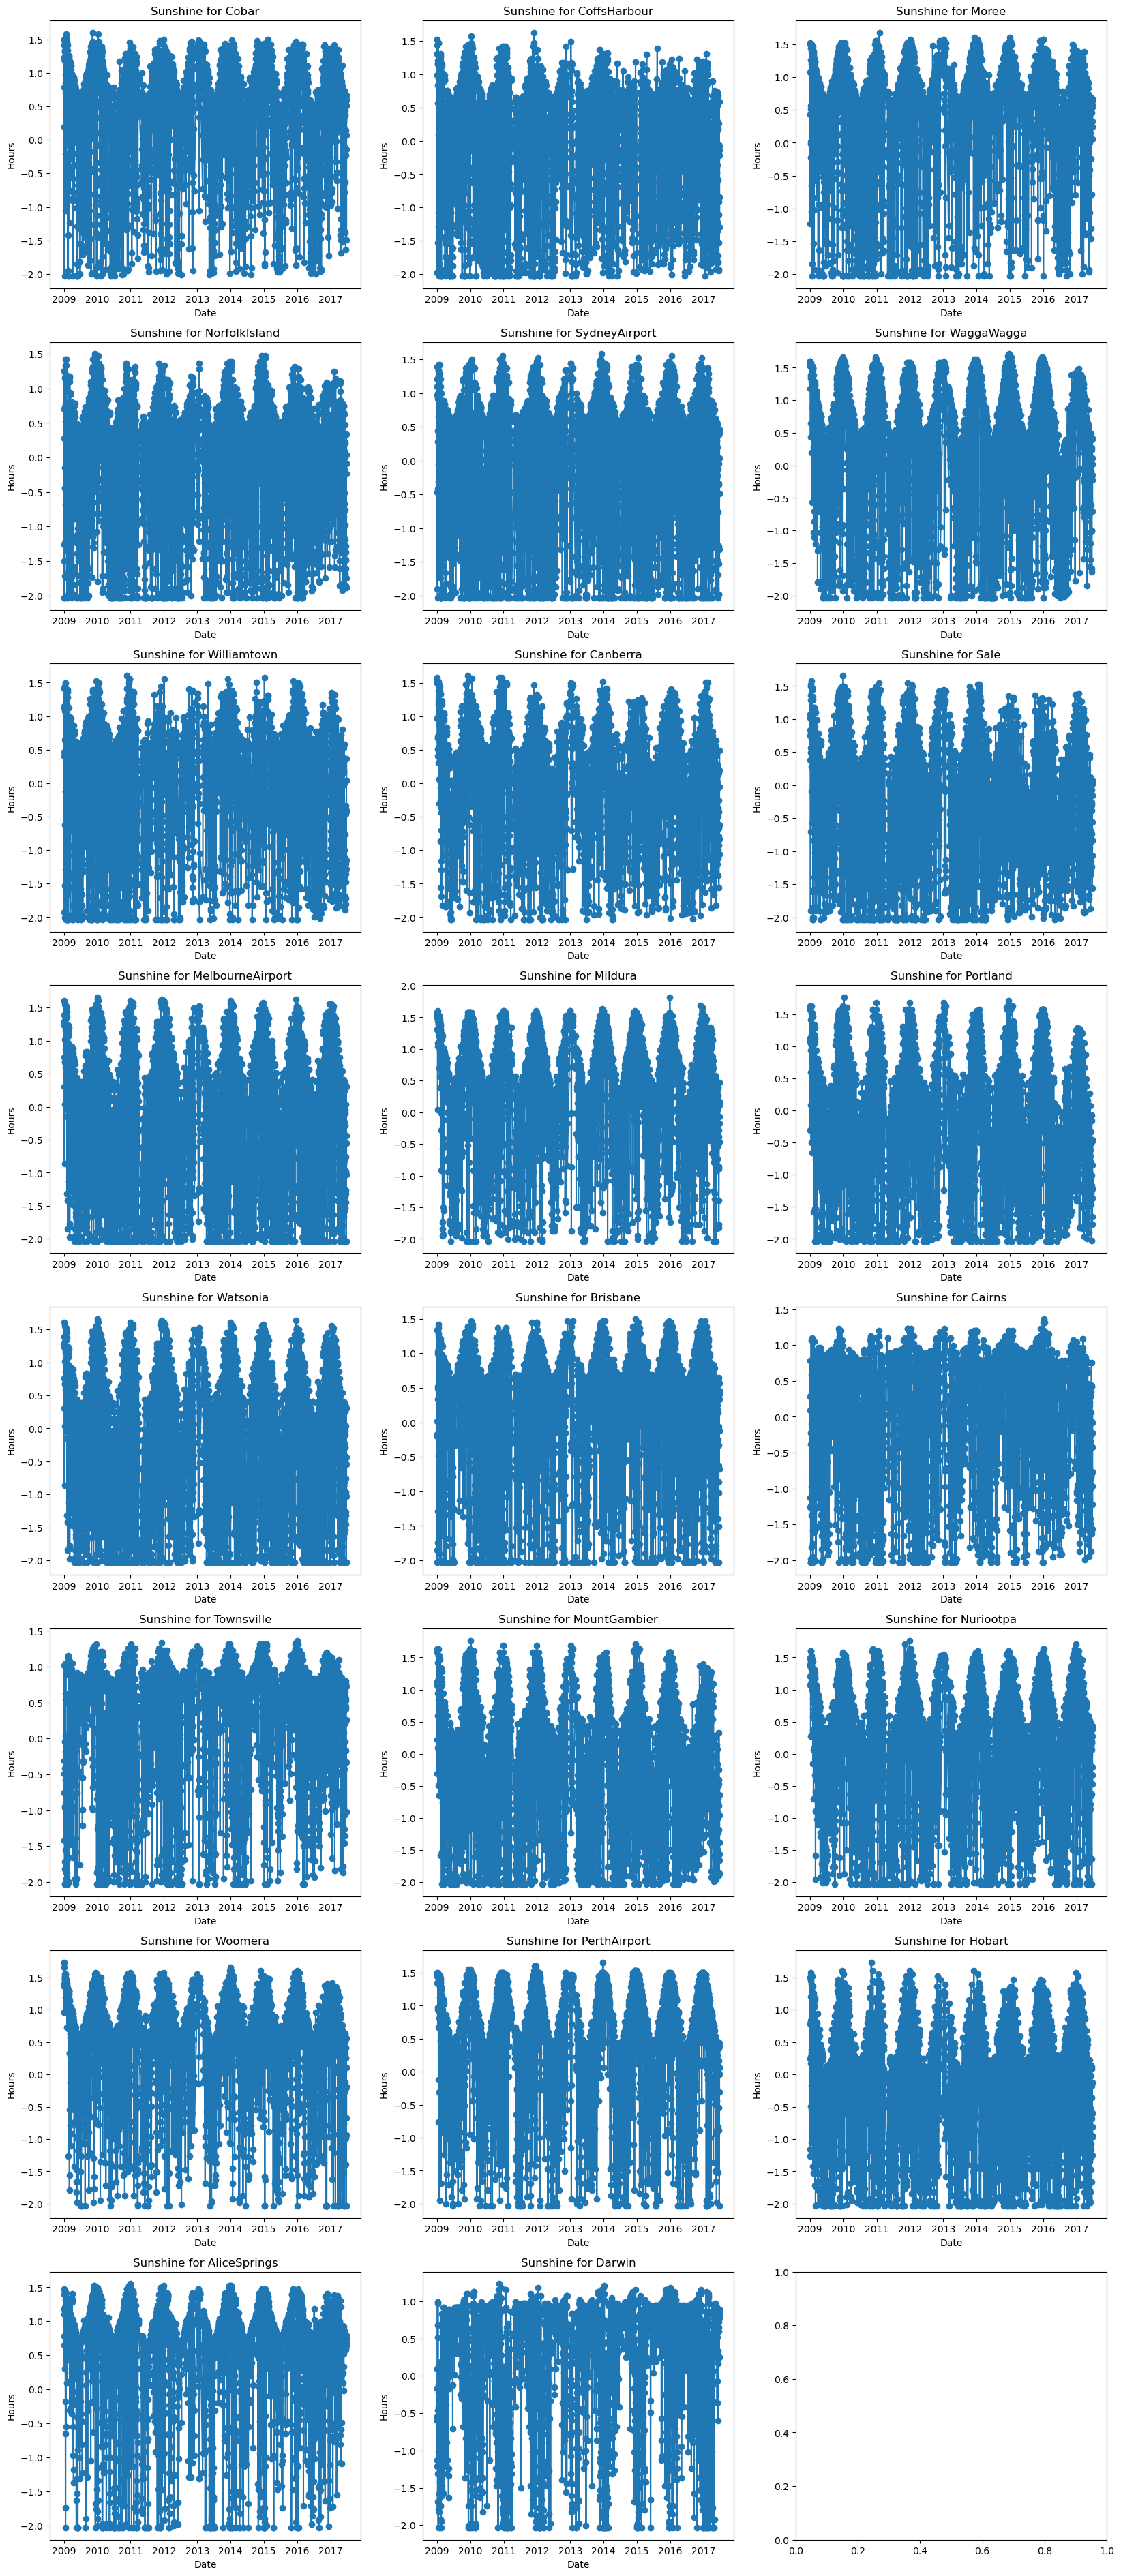

In [21]:
num_locations = len(df['Location'].unique())
num_cols = 3 # Number of columns for the subplots
num_rows = (num_locations + num_cols - 1) // num_cols

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6))

# Flatten the array for easy iteration
axs = axs.flatten()
locations = []
for i,location in enumerate(df['Location'].unique()):
    df_location = df.loc[(df.Location==location)]
    axs[i].plot(df_location.Date, df_location.Sunshine, marker='o', linestyle='-')
    axs[i].set_title(f'Sunshine for {location}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Hours')

In [22]:
print(df.isna().sum())
print(df.shape)

Date                 0
Location             0
Year                 0
Month                0
RainToday            0
RainTomorrow         0
Rainfall             0
Evaporation          0
Sunshine             0
WindGustSpeed        0
WindGustDir_angle    0
Latitude             0
Longitude            0
Cloud                0
Pressure             0
Temperature          0
Humidity             0
temp_fluctuation     0
dtype: int64
(67725, 18)


In [23]:
df.to_csv('weatherAUS_imputed.csv', index=False)